In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

#https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99

/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_file = "./dataset/train.csv"
test_file = "./dataset/test.csv"
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_train, x_val, y_train, y_val = train_test_split(raw_data[:, 1:], raw_data[:, 0], test_size=0.1)

Text(0.5,1,'28*28 data')

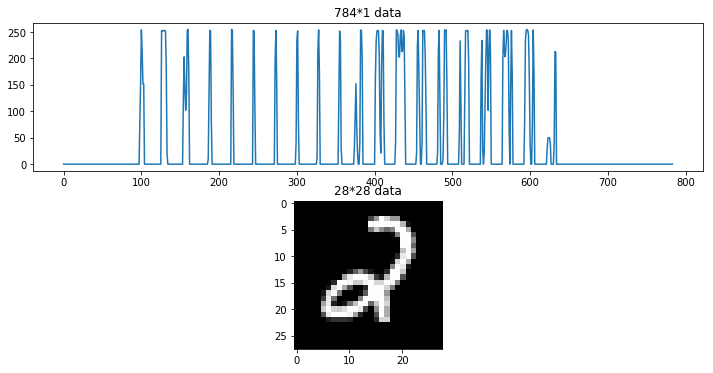

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(x_train[0])
ax[0].set_title('784*1 data')
ax[1].imshow(x_train[0].reshape(28, 28), cmap='gray')
ax[1].set_title('28*28 data')

In [4]:
def convertOneHot(y, C):
    return np.eye(C)[y.reshape(-1)]

In [5]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_train = x_train.astype("float32")/255
x_val = x_val.astype("float32")/255
y_train = convertOneHot(y_train, 10)
y_val = convertOneHot(y_val, 10)

In [6]:
print(y_train[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
def model(x, classnum):
    with tf.variable_scope('layer1'):
        layer1 = tf.layers.conv2d(x, 16, 3, strides=1, padding='VALID')
        relu1 = tf.nn.relu(layer1)
        norm1 = tf.layers.batch_normalization(relu1, center=True, scale=True, training=True)
    with tf.variable_scope('layer2'):
        layer2 = tf.layers.conv2d(norm1, 16, 3 , strides=1, padding='VALID')
        norm2 = tf.layers.batch_normalization(layer2, center=True, scale=True, training=True)
        pool2 = tf.layers.max_pooling2d(norm2, pool_size=[2, 2], strides=2, padding='SAME')
        drop2 = tf.layers.dropout(pool2, 0.25)
    with tf.variable_scope('layer3'):
        layer3 = tf.layers.conv2d(drop2, 32, 3, strides=1, padding='VALID')
        relu3 = tf.nn.relu(layer3)
        norm3 = tf.layers.batch_normalization(relu3, center=True, scale=True, training=True)
    with tf.variable_scope('layer4'):
        layer4 = tf.layers.conv2d(norm3, 32, 3, strides=1, padding='VALID')
        relu4 = tf.nn.relu(layer4)
        norm4 = tf.layers.batch_normalization(relu4, center=True, scale=True, training=True)
        pool4 = tf.layers.max_pooling2d(norm4, pool_size=[2, 2], strides=2, padding='SAME')
        drop4 = tf.layers.dropout(pool4, 0.25)
    with tf.variable_scope('layer5'):
        flatten = tf.reshape(drop4, [-1, 4*4*32])
        layer5 = tf.layers.dense(flatten, 512)
        relu5 = tf.nn.relu(layer5)
        drop5 = tf.layers.dropout(relu5, 0.25)
    with tf.variable_scope('layer6'):
        layer6 = tf.layers.dense(drop5, 1024)
        relu6 = tf.nn.relu(layer6)
        drop6 = tf.layers.dropout(relu6, 0.5)
        logits = tf.layers.dense(drop6, classnum)
    return logits

In [8]:
x_data = tf.placeholder(tf.float32, [None, 28, 28, 1])
y_data = tf.placeholder(tf.float32, [None, None])
model_save_path = "./model/model.ckpt"
out = model(x_data, 10)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=y_data))
train_step = tf.train.AdadeltaOptimizer(0.1).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, 1), tf.argmax(y_data, 1)), tf.float32))
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epoch = 50
    batch_size = 100
    num_batch = len(x_train) // batch_size
    for n in range(epoch):
        for i in range(num_batch):
            x_batch = x_train[i*batch_size : (i+1)*batch_size]
            y_batch = y_train[i*batch_size : (i+1)*batch_size]
            _, loss_step = sess.run([train_step, loss], \
                              feed_dict={x_data:x_batch, y_data:y_batch})
            if (i == 0):
                print(n, loss_step)
                acc = accuracy.eval({x_data:x_val, y_data:y_val})
                print("val: accuracy is ", acc)
    #saver.save(sess, model_save_path, global_step=n+1)
    saver.save(sess, model_save_path)
    print("Finsihed")
    #混淆矩阵
    sess.run(out, feed_dict={x_data: x_val})
    y_hat = out.eval({x_data: x_val})
    y_pred = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y_val, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

0 2.5409641
val: accuracy is  0.14285715
1 0.15188761
val: accuracy is  0.9492857
2 0.070396006
val: accuracy is  0.9678571
3 0.050263952
val: accuracy is  0.9759524
4 0.039834104
val: accuracy is  0.9797619
5 0.034053437
val: accuracy is  0.98142856
6 0.028959956
val: accuracy is  0.98261905
7 0.024746776
val: accuracy is  0.98333335
8 0.021156926
val: accuracy is  0.98380953
9 0.018427588
val: accuracy is  0.98380953
10 0.015607519
val: accuracy is  0.9842857
11 0.0132815335
val: accuracy is  0.9842857
12 0.01154187
val: accuracy is  0.98452383
13 0.009831426
val: accuracy is  0.9847619
14 0.008358707
val: accuracy is  0.985
15 0.0069838385
val: accuracy is  0.9854762
16 0.0059127794
val: accuracy is  0.9852381
17 0.0049981354
val: accuracy is  0.98571426
18 0.0042340686
val: accuracy is  0.9857142

In [9]:
model_save_path = "./model/model.ckpt"

def testModel(ckpt_path):
    tf.reset_default_graph()#mo
    x_val_data = tf.placeholder(tf.float32, [None, 28, 28, 1])
    y_val_data = tf.placeholder(tf.float32, [None, None]) 
    out = model(x_val_data, 10)

    saver = tf.train.Saver()
    #accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, 1), tf.argmax(y_val_data, 1)), tf.float32))
    with tf.Session() as sess:
        #tf.reset_default_graph()
        saver.restore(sess, ckpt_path)
        sess.run(out, feed_dict={x_val_data:x_val})
        y_hat = out.eval({x_val_data: x_val})
        y_pred = np.argmax(y_hat, axis=1)
        y_true = np.argmax(y_val, axis=1)
        cm = confusion_matrix(y_true, y_pred)
        print(cm)

In [10]:
testModel(model_save_path)

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
[[411   0   0   0   0   0   1   0   1   0]
 [  0 450   1   0   1   0   1   1   0   0]
 [  1   0 410   3   0   0   1   3   3   0]
 [  0   0   5 440   0   1   0   1   0   1]
 [  0   0   0   0 382   0   0   1   0   2]
 [  0   0   0   2   0 366   1   0   0   1]
 [  1   0   0   0   0   1 426   0   1   0]
 [  1   1   3   0   0   0   0 453   1   0]
 [  1   2   1   0   1   0   0   0 361   2]
 [  1   0   1   1   3   2   0   2   3 440]]


In [11]:
test_file = "./dataset/test.csv"
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1)/255

In [12]:
model_save_path = "./model/model.ckpt"
output_file = "submission.csv"
def submit():
    tf.reset_default_graph()
    x_test_data = tf.placeholder(tf.float32, [None, 28, 28, 1])
    logits = model(x_test_data, 10)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, model_save_path)
        sess.run(logits, feed_dict={x_test_data:x_test})
        y_hat = logits.eval({x_test_data: x_test})
        y_pred = np.argmax(y_hat, axis=1)
        with open(output_file, 'w') as f:
            f.write('ImageId,label\n')
            for i in range(len(y_pred)):
                f.write("".join([str(i+1), ',', str(y_pred[i]), '\n']))

In [13]:
submit()

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
